In [1]:
"""
take-profits can no longer be hit in the same bar
they were opened unless that bar’s close crosses the TP level.
If a bar touches both TP and SL levels, SL always wins.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path

# ───────────────────── CONFIG ──────────────────────
@dataclass
class Config:
    data_path: Path = Path("C:/Users/user/Desktop/bybithistory/download/alldata/TRBUSDT.csv")
    H: int = 9          # look-back window (minutes) for avg range R
    K: float = 9        # stop-loss factor (distance = ½·R·K)
    M: float = 1.0      # contract multiplier (BTC per contract)
    initial_equity: float = 100_000
    slippage_pct: float = 0.0035   # 0.3% slippage on stop-loss exits + +0.05% market fee
    min_r_half_pct: float = 0.0015  

# ───────────────────── DATA I/O ────────────────────
def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["datetime_utc"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    return (
        df[["datetime_utc", "open", "high", "low", "close", "volume"]]
        .sort_values("datetime_utc")
        .reset_index(drop=True)
    )

# ────────────── SIZING HELPERS ───────────────
def make_weights(n_tiers: int, start: float = 0.10, growth: float = 0.75):
    raw = start * growth ** np.arange(n_tiers)
    return raw / raw.sum()

# Nine-tier ladder: F factors 6.0 … 8.5 in 0.5 steps
F_GRID = np.arange(6.0, 9.0, 0.5)
W_GRID = make_weights(len(F_GRID))
DIR    = {"long": 1, "short": -1}

# ────────────── STRATEGY CLASS ───────────────
class RangeScalperLadder:
    def __init__(self, df: pd.DataFrame, H: int, K: float,
                 min_r_half_pct: float = 0.0005):
        self.df = df.copy()
        self.H, self.K = H, K
        self.min_r_half_pct = min_r_half_pct
        self.F_grid, self.W_grid = F_GRID, W_GRID
        self._prepare()

    # ---------- internal ----------
    def _prepare(self):
        self.df["R"] = (self.df["high"] - self.df["low"]).rolling(self.H).mean()

    # ---------- helpers ----------
    def _open_position(self, idx, side, fills_bool, mid, e_dists, R):
        """Create a new position object with per-tier bookkeeping."""
        tiers   = np.where(fills_bool)[0]
        prices  = mid - DIR[side] * e_dists[tiers]
        sizes   = self.W_grid[tiers]
        now     = self.df.iloc[idx]["datetime_utc"]

        tp_prices  = {}
        entry_times = {}
        tier_sizes  = {}
        for t, p, sz in zip(tiers, prices, sizes):
            dist  = 0.5 * R * (self.K - self.F_grid[t])
            tp_prices[t]  = p + DIR[side] * dist
            entry_times[t] = now
            tier_sizes[t]  = sz

        return {
            "idx_open": idx,
            "side": side,
            "tiers_filled": set(tiers),
            "entry_prices": dict(zip(tiers, prices)),
            "entry_times": entry_times,
            "tier_sizes": tier_sizes,
            "size_filled": sizes.sum(),
            "tp_prices": tp_prices,
            "sl_price": mid - DIR[side] * 0.5 * R * self.K,
        }

    # ★★★★★  UPDATED SECTION  ★★★★★
    def _manage_position(self, i_idx: int, pos: dict, row: pd.Series, R: float):
        """Update stops, check fills, execute TP/SL, return (trades, new_pos)."""
        trades, side, DIR_S = [], pos["side"], DIR[pos["side"]]
        h, l, c = row["high"], row["low"], row["close"]

        # ── 1.  Possible extra ladder fills ────────────────────────────────
        prev_close = self.df.iloc[i_idx - 1]["close"]
        e_dists    = 0.5 * R * self.F_grid
        fills      = (l < prev_close - e_dists) if side == "long" \
                     else (h > prev_close + e_dists)
        new_tiers  = set(np.where(fills)[0]) - pos["tiers_filled"]

        if new_tiers:
            now = row["datetime_utc"]
            for t in new_tiers:
                p = prev_close - DIR_S * e_dists[t]
                pos["entry_prices"][t] = p
                pos["entry_times"][t]  = now
                pos["tier_sizes"][t]   = self.W_grid[t]
                dist = 0.5 * R * (self.K - self.F_grid[t])
                pos["tp_prices"][t] = p + DIR_S * dist
            pos["tiers_filled"].update(new_tiers)
            pos["size_filled"] = sum(pos["tier_sizes"].values())

        # ── 2.  Shared stop-loss (SL first; overrides TP if both hit) ──────
        sl_hit = (side == "long" and l <= pos["sl_price"]) or \
                 (side == "short" and h >= pos["sl_price"])

        if sl_hit:
            for t in list(pos["tiers_filled"]):
                trades.append({
                    "entry_time": pos["entry_times"][t],
                    "exit_time" : row["datetime_utc"],
                    "side"      : side,
                    "entry_price": pos["entry_prices"][t],
                    "exit_price" : pos["sl_price"],
                    "exit_type" : "sl",
                    "filled_size": pos["tier_sizes"][t],
                    "tiers"     : [t],
                })
            return trades, None  # flat

        # ── 3.  Tier-level take-profits ────────────────────────────────────
        hit = []
        for t, tp in pos["tp_prices"].items():
            same_bar = pos["entry_times"][t] == row["datetime_utc"]
            if same_bar:
                cond = (side == "long" and c >= tp) or \
                       (side == "short" and c <= tp)
            else:
                cond = (side == "long" and h >= tp) or \
                       (side == "short" and l <= tp)
            if cond:
                hit.append(t)

        for t in hit:
            trades.append({
                "entry_time": pos["entry_times"][t],
                "exit_time" : row["datetime_utc"],
                "side"      : side,
                "entry_price": pos["entry_prices"][t],
                "exit_price" : pos["tp_prices"][t],
                "exit_type" : "tp",
                "filled_size": pos["tier_sizes"][t],
                "tiers"     : [t],
            })
            for k in ("entry_prices", "entry_times", "tier_sizes", "tp_prices"):
                del pos[k][t]
            pos["tiers_filled"].remove(t)

        pos["size_filled"] = sum(pos["tier_sizes"].values())

        # ── 4.  Flat? ──────────────────────────────────────────────────────
        if not pos["tiers_filled"]:
            return trades, None

        # keep position alive
        return trades, pos

    # ---------- public ----------
    def run(self) -> pd.DataFrame:
        trades, active = [], None

        for i in range(self.H, len(self.df)):
            row, prev = self.df.iloc[i], self.df.iloc[i - 1]
            R = row["R"]
            if np.isnan(R) or R <= 0:
                continue

            e_dists = 0.5 * R * self.F_grid
            mid_prev = prev["close"]

            # hard filter
            if (0.5 * R) / mid_prev < self.min_r_half_pct and active is None:
                continue

            # ── ENTRY ──────────────────────────────────────────────────────
            if active is None:
                fills_long  = row["low"]  < (mid_prev - e_dists)
                fills_short = row["high"] > (mid_prev + e_dists)
                if fills_long.any():
                    active = self._open_position(i, "long", fills_long, mid_prev, e_dists, R)
                elif fills_short.any():
                    active = self._open_position(i, "short", fills_short, mid_prev, e_dists, R)
                continue

            # ── MANAGE ─────────────────────────────────────────────────────
            closed, active = self._manage_position(i, active, row, R)
            trades.extend(closed)

        return pd.DataFrame(trades)

In [2]:
cfg = Config()
df  = load_data(cfg.data_path)

commission_rates = [0.00015]     
metrics, eq_curves, dd_curves, returns_by_rate = [], {}, {}, {}

for rate in commission_rates:
    scalper = RangeScalperLadder(df, cfg.H, cfg.K, cfg.min_r_half_pct)
    trades  = scalper.run().sort_values("exit_time").reset_index(drop=True)

    equity = cfg.initial_equity
    eq_series, dd_series, rec = [], [], []

    for _, t in trades.iterrows():
        ep, xp, side, e_type = t["entry_price"], t["exit_price"], t["side"], t["exit_type"]

        # slippage only on SL exits
        if e_type == "sl":
            xp *= (1 - cfg.slippage_pct) if side == "long" else (1 + cfg.slippage_pct)

        units = equity * t["filled_size"] / (ep * cfg.M)
        direction = 1 if side == "long" else -1
        gross_pnl = units * cfg.M * (xp - ep) * direction
        commission = rate * units * cfg.M * (ep + xp)
        pnl = gross_pnl - commission

        prev_eq = equity
        equity += pnl
        eq_series.append((t["exit_time"], equity))
        running_max = max([e for _, e in eq_series] + [cfg.initial_equity])
        dd_series.append((t["exit_time"], equity / running_max - 1))

        rec.append({
            "pnl": pnl,
            "return_pct": pnl / prev_eq * 100,
            "hold_min": (t["exit_time"] - t["entry_time"]).total_seconds() / 60,
            "side": side,
            "exit_type": e_type,
        })

    tr = pd.DataFrame(rec)
    returns_by_rate[rate] = tr

    win = tr[tr.pnl > 0]
    loss = tr[tr.pnl <= 0]
    metrics.append({
        "rate": rate,
        "trades": len(tr),
        "win_rate_%": len(win) / len(tr) * 100 if len(tr) else np.nan,
        "avg_return_%": tr["return_pct"].mean(),
        "avg_win_%": win["return_pct"].mean(),
        "avg_loss_%": loss["return_pct"].mean(),
        "avg_hold_win_min": win["hold_min"].mean(),
        "avg_hold_loss_min": loss["hold_min"].mean(),
        "profit_factor": win.pnl.sum() / (-loss.pnl.sum()) if loss.pnl.sum() else np.nan,
        "max_dd_%": min([d for _, d in dd_series]) * 100 if dd_series else 0,
    })
    eq_curves[rate] = pd.DataFrame(eq_series, columns=["time", "equity"])
    dd_curves[rate] = pd.DataFrame(dd_series, columns=["time", "drawdown"])

In [3]:
print(pd.DataFrame(metrics).to_string(index=False))

   rate  trades  win_rate_%  avg_return_%  avg_win_%  avg_loss_%  avg_hold_win_min  avg_hold_loss_min  profit_factor   max_dd_%
0.00015    5487   69.436851      0.022225   0.134421   -0.232675          1.837533           2.370304       1.251756 -14.905019


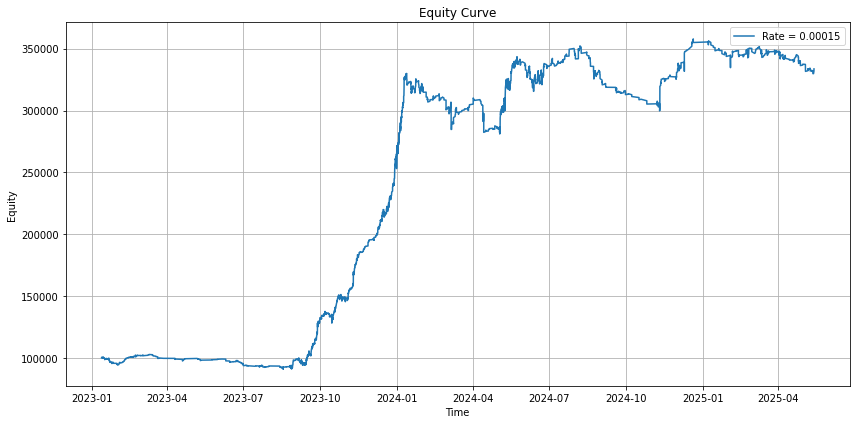

In [4]:
plt.figure(figsize=(12, 6))
for rate, df_eq in eq_curves.items():
    x = df_eq["time"].to_numpy()
    y = df_eq["equity"].to_numpy()
    plt.plot(x, y, label=f"Rate = {rate}")
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

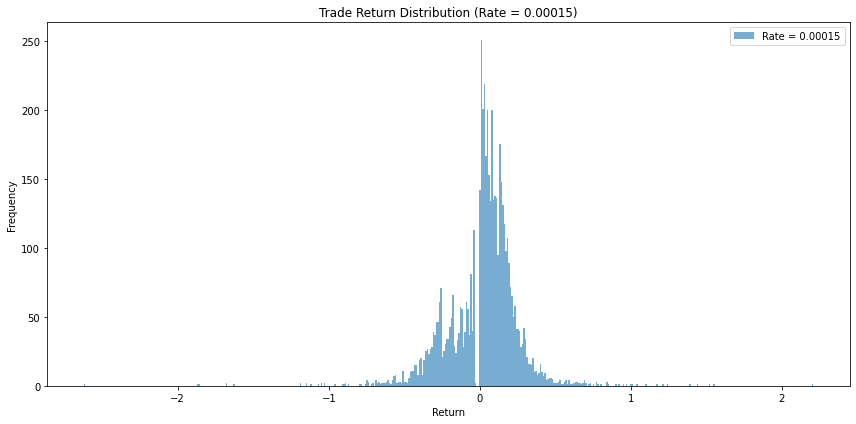

In [5]:
for rate, tr in returns_by_rate.items():
    rtn = tr["return_pct"]
    bins = np.arange(rtn.min(), rtn.max() + 0.01, 0.01)

    plt.figure(figsize=(12, 6))
    plt.hist(rtn, bins=bins, alpha=0.6, label=f"Rate = {rate}")
    plt.title(f"Trade Return Distribution (Rate = {rate})")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()